In [1]:
import sys
!{sys.executable} -m pip install spotipy

In [2]:
import spotipy 
from spotipy.oauth2 import SpotifyClientCredentials
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import warnings
import math
import time
warnings.simplefilter("ignore")

In [3]:
sp = spotipy.Spotify()

USER_ID = "emilyrlandman"
TOP10_PLAYLIST_ID = "1ggWDL88pSeijtf7zifvF1"
ALBUMS_PLAYLIST_ID = "5YVVRDq8QLSB2wJ2lvq3Dx"
CLIENT_ID = "27a2df6fdb064b40b952dbe55f451421" 
CLIENT_SECRET = "a97bf4bf619b4239961eb80513e2c0e0" 
CLIENT_CREDENTIALS = SpotifyClientCredentials(client_id=CLIENT_ID, client_secret=CLIENT_SECRET) 

sp = spotipy.Spotify(client_credentials_manager=CLIENT_CREDENTIALS) 
sp.trace=False

### Label Encoder

In [4]:
# First we have to gather the total number of tracks in the playlist 
track_count = sp.user_playlist_tracks(USER_ID, TOP10_PLAYLIST_ID, 'total')['total']

# Then we calculate the number of times we'll have to call the API
iterations = math.ceil(track_count/100)

# Finally we begin our loop
attributes_df = pd.DataFrame()
information_df = pd.DataFrame()
for i in range(iterations):
    playlist = sp.user_playlist_tracks(USER_ID, TOP10_PLAYLIST_ID, None, None, i*100) # documentation - https://spotipy.readthedocs.io/en/2.13.0/
    songs = playlist["items"]
#     time.sleep(1) # incase this is necessary on larger playlists

    track_ids = []
    track_names = []
    track_popularities = []
    track_explicit = []
    artist_ids = []
    artist_names = []
    artist_popularities = []
    artist_followers = []
    artist_genres = []
    
    for j in range(len(songs)): 
        track_ids.append(songs[j]["track"]["id"])
        track_names.append(songs[j]["track"]["name"])
        track_popularities.append(songs[j]["track"]["popularity"])
        track_explicit.append(songs[j]["track"]["explicit"])
        artist_names.append(songs[j]["track"]["artists"][0]["name"])
        
        artist_id = songs[j]["track"]["artists"][0]["id"]
        artist_ids.append(artist_id)
        artist = sp.artist(artist_id)
        artist_popularities.append(artist['popularity'])
        artist_followers.append(artist['followers']['total'])
        artist_genres.append(artist['genres'])

        
    features = sp.audio_features(track_ids)
    att_df = pd.DataFrame(features)
    info_df = pd.DataFrame({"song_id":track_ids, 
                            "song_name":track_names, 
                            "song_popularity":track_popularities,
                            "explicit":track_explicit,
                            "artist_id":artist_ids, 
                            "artist": artist_names, 
                            "artist popularity": artist_popularities,
                            "artist followers": artist_followers,
                            "genre": artist_genres})
    
    attributes_df = attributes_df.append(att_df, ignore_index=True)
    information_df = information_df.append(info_df, ignore_index=True)

TOP_df = information_df.merge(attributes_df, left_on="song_id", right_on="id")
TOP_df = TOP_df.drop_duplicates(['song_id'])
TOP_df.reset_index(inplace=True, drop=True)
TOP_df["top_10"] = 1
# TOP_df

In [5]:
# First we have to gather the total number of tracks in the playlist 
track_count = sp.user_playlist_tracks(USER_ID, ALBUMS_PLAYLIST_ID, 'total')['total']

# Then we calculate the number of times we'll have to call the API
iterations = math.ceil(track_count/100)

# Finally we begin our loop
attributes_df = pd.DataFrame()
information_df = pd.DataFrame()
for i in range(iterations):
    playlist = sp.user_playlist_tracks(USER_ID, ALBUMS_PLAYLIST_ID, None, None, i*100) # documentation - https://spotipy.readthedocs.io/en/2.13.0/
    songs = playlist["items"]
#     time.sleep(1) # incase this is necessary on larger playlists

    track_ids = []
    track_names = []
    track_popularities = []
    track_explicit = []
    artist_ids = []
    artist_names = []
    artist_popularities = []
    artist_followers = []
    artist_genres = []
    
    for j in range(len(songs)): 
        track_ids.append(songs[j]["track"]["id"])
        track_names.append(songs[j]["track"]["name"])
        track_popularities.append(songs[j]["track"]["popularity"])
        track_explicit.append(songs[j]["track"]["explicit"])
        artist_names.append(songs[j]["track"]["artists"][0]["name"])
        
        artist_id = songs[j]["track"]["artists"][0]["id"]
        artist_ids.append(artist_id)
        artist = sp.artist(artist_id)
        artist_popularities.append(artist['popularity'])
        artist_followers.append(artist['followers']['total'])
        artist_genres.append(artist['genres'])

        
    features = sp.audio_features(track_ids)
    att_df = pd.DataFrame(features)
    info_df = pd.DataFrame({"song_id":track_ids, 
                            "song_name":track_names, 
                            "song_popularity":track_popularities,
                            "explicit":track_explicit,
                            "artist_id":artist_ids, 
                            "artist": artist_names, 
                            "artist popularity": artist_popularities,
                            "artist followers": artist_followers,
                            "genre": artist_genres})
    
    attributes_df = attributes_df.append(att_df, ignore_index=True)
    information_df = information_df.append(info_df, ignore_index=True)
    
ALBUMS_df = information_df.merge(attributes_df, left_on="song_id", right_on="id")
ALBUMS_df["top_10"] = 0
# ALBUMS_df

In [6]:
FULL_df = TOP_df.append(ALBUMS_df, ignore_index=True)
FULL_df.drop_duplicates(["song_id"], inplace=True)
FULL_df.reset_index(inplace=True, drop=True)
#FULL_df


In [7]:
allGenres = FULL_df["genre"].explode()
allGenres.value_counts().to_csv("genre_count.csv")
allGenres.value_counts().head(50)

pop                       1465
dance pop                 1183
post-teen pop              595
pop rap                    592
pop rock                   454
rap                        452
urban contemporary         443
r&b                        383
hip pop                    301
hip hop                    294
neo mellow                 262
southern hip hop           174
post-grunge                160
atl hip hop                148
neo soul                   123
trap                       123
canadian pop               110
electropop                 110
uk pop                     100
alternative metal           96
rock                        94
gangster rap                85
talent show                 75
nu metal                    74
edm                         73
queens hip hop              69
south carolina hip hop      66
modern rock                 66
europop                     65
pop punk                    64
dirty south rap             64
contemporary country        63
boy band

In [8]:
#Adding columns for the most common genres

pop = [0]*len(FULL_df.index)
rap = [0]*len(FULL_df.index)
rnb = [0]*len(FULL_df.index)
edm = [0]*len(FULL_df.index)
rock = [0]*len(FULL_df.index)
latin = [0]*len(FULL_df.index)
hiphop = [0]*len(FULL_df.index)
mellow = [0]*len(FULL_df.index)
country = [0]*len(FULL_df.index)


for i in range(len(FULL_df["genre"])):
    for item in FULL_df["genre"][i]:

        if (("edm" in item) or 
            ("dance" in item) or 
            ("vapor" in item) or 
            ("techno" in item) or 
            ("electro" in item) or 
            ("brostep" in item) or 
            ("complextro" in item))\
        and (("dancehall" not in item) and
             ("dance pop" not in item)):
            edm[i]=1
            
        if (("rock" in item) or 
            ("punk" in item) or
            ("metal" in item) or
            ("indie" in item) or
            ("grunge" in item) or
            ("baroque" in item) or
            ("permanent wave" in item)):
            rock[i]=1

        if ("pop" in item)\
        and (("punk" not in item) and 
             ("rock" not in item) and 
             ("baroque" not in item) and 
             ("dance pop" not in item) and 
             ("indie poptimism" not in item)):
            pop[i]=1
            
        if (("hip" in item) or 
            ("hop" in item) or 
            ("dancehall" in item) or 
            ("new jack swing" in item)):
            hiphop[i]=1
            
        if (("r&b"in item) or
            ("soul"in item) or
            ("motown"in item) or
            ("quiet storm" in item)):
            rnb[i]=1

        if (("rap" in item) or 
            ("urban" in item))\
        and ("vapor" not in item):
            rap[i]=1
            
        if (("country"in item) or
            ("lilith" in item)):
            country[i]=1

        if "mellow" in item:
            mellow[i]=1
            
        if "latin" in item:
            latin[i]=1

# In order of most appearing (done in excel)   
FULL_df["pop"] = pop
FULL_df["rap"] = rap
FULL_df["hiphop"] = hiphop
FULL_df["rock"] = rock
FULL_df["rnb"] = rnb
FULL_df["country"] = country
FULL_df["mellow"] = mellow
FULL_df["edm"] = edm
FULL_df["latin"] = latin

FULL_df

,song_id,song_name,song_popularity,explicit,artist_id,artist,artist popularity,artist followers,genre,danceability,...,top_10,pop,rap,hiphop,rock,rnb,country,mellow,edm,latin
0,3y4LxiYMgDl4RethdzpmNe,Breathe,65,False,25NQNriVT2YbSW80ILRWJa,Faith Hill,67,1135327,"[contemporary country, country, country dawn, ...",0.529,...,1,0,0,0,1,0,1,0,0,0
1,3i3GeK0qLQybu4ah42YmCY,Smooth (feat. Rob Thomas),54,False,6GI52t8N5F02MxU0g5U69P,Santana,74,1616127,"[blues rock, classic rock, mexican classic roc...",0.612,...,1,0,0,0,1,0,0,0,0,0
2,3fucYASejkSMwtAYjFRKlF,Maria Maria (feat. The Product G&B),53,False,6GI52t8N5F02MxU0g5U69P,Santana,74,1616127,"[blues rock, classic rock, mexican classic roc...",0.779,...,1,0,0,0,1,0,0,0,0,0
3,6ctr1K7KzKErxbfGAynL8A,I Wanna Know,57,False,3zTOe1BtyTkwNvYZOxXktX,Joe,67,1039439,"[dance pop, hip pop, neo soul, new jack swing,...",0.724,...,1,1,1,1,0,1,0,0,0,0
4,4cKGldbhGJniI8BrB3K6tb,Everything You Want,64,False,6Hizgjo92FnMp8wGaRUNTn,Vertical Horizon,56,280308,"[neo mellow, pop rock, post-grunge]",0.637,...,1,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2325,5MoU7TaAvgBa8W0XVwXAd7,Trust,54,False,7gOdHgIoIKoe4i9Tta6qdD,Jonas Brothers,83,4309395,"[boy band, dance pop, pop, pop rock, post-teen...",0.806,...,0,1,0,0,1,0,0,0,0,0
2326,5md87aD3pGXRghKUbZdyh8,Strangers,58,False,7gOdHgIoIKoe4i9Tta6qdD,Jonas Brothers,83,4309395,"[boy band, dance pop, pop, pop rock, post-teen...",0.594,...,0,1,0,0,1,0,0,0,0,0
2327,7fiFJADUcHwTdYLmnZeLAy,Hesitate,62,False,7gOdHgIoIKoe4i9Tta6qdD,Jonas Brothers,83,4309395,"[boy band, dance pop, pop, pop rock, post-teen...",0.622,...,0,1,0,0,1,0,0,0,0,0
2328,7dxKdQC9Vo1hDxIUnt1z0Q,Rollercoaster,66,False,7gOdHgIoIKoe4i9Tta6qdD,Jonas Brothers,83,4309395,"[boy band, dance pop, pop, pop rock, post-teen...",0.697,...,0,1,0,0,1,0,0,0,0,0


In [9]:
#Set up data

# Assign X (data) and y (target)
X = FULL_df.drop(['song_id', 'song_name',
                  'artist_id', 'genre', 
                  'type', 'id', 'uri', 'track_href', 'analysis_url',
                  'top_10'], axis=1)
# X = X.drop(['artist popularity', 'artist followers'], axis=1)
# X = X.drop(['song_popularity'], axis=1)

y = FULL_df['top_10']
print(X.shape, y.shape)

# Select random state for Notebook
rs = 69

# Encode Strings in "Artist Column"
from sklearn.preprocessing import LabelEncoder
encode = LabelEncoder()
X['artist'] = encode.fit_transform(X['artist'])

#Split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rs)

(2330, 27) (2330,)


In [10]:
X_train

,song_popularity,explicit,artist,artist popularity,artist followers,danceability,energy,key,loudness,mode,...,time_signature,pop,rap,hiphop,rock,rnb,country,mellow,edm,latin
778,33,False,100,70,1131386,0.607,0.947,4,-3.524,0,...,4,1,0,0,0,0,0,0,0,0
2122,49,True,94,90,9280058,0.787,0.479,1,-8.247,0,...,4,1,1,1,0,0,0,0,0,0
199,84,False,74,83,4309395,0.842,0.734,1,-5.065,0,...,4,1,0,0,1,0,0,0,0,0
1317,21,False,139,68,707521,0.568,0.759,0,-6.496,1,...,4,1,0,0,1,0,0,0,0,0
1541,41,False,163,82,7829731,0.789,0.831,2,-4.269,0,...,4,1,1,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1208,46,False,11,76,1748080,0.552,0.535,0,-4.713,1,...,4,1,1,1,0,0,0,0,0,0
1033,60,False,120,89,16557948,0.374,0.659,8,-5.472,1,...,4,1,0,0,0,0,0,0,0,0
278,59,False,84,92,12021794,0.213,0.414,0,-9.725,1,...,4,1,0,0,0,1,0,0,0,0
439,65,True,82,88,15005713,0.588,0.479,1,-7.039,1,...,4,0,1,1,0,0,0,0,0,0


### Logistic Regression

Training Data Score: 0.6559816828849456
Testing Data Score: 0.6535162950257289

              precision    recall  f1-score   support

    negative       0.96      0.65      0.77       530
    positive       0.17      0.72      0.27        53

    accuracy                           0.65       583
   macro avg       0.56      0.68      0.52       583
weighted avg       0.89      0.65      0.73       583



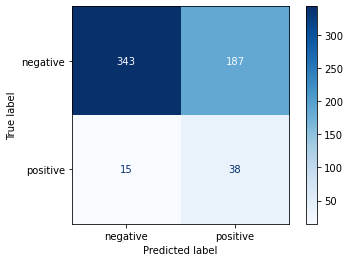

In [11]:
#create model
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(class_weight = 'balanced')

#train model
classifier.fit(X_train, y_train)

#test model
print(f"Training Data Score: {classifier.score(X_train, y_train)}")
print(f"Testing Data Score: {classifier.score(X_test, y_test)}\n")

# Calculate classification report
target_names = ["negative", "positive"]
from sklearn.metrics import classification_report
predictions = classifier.predict(X_test)
print(classification_report(y_test, predictions,
                            target_names=target_names))

from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(classifier, X_test, y_test, cmap=plt.cm.Blues, display_labels=target_names)
plt.show()

### Decision Tree

Training Data Score: 1.0
Testing Data Score: 0.8936535162950258

              precision    recall  f1-score   support

    negative       0.93      0.95      0.94       530
    positive       0.39      0.30      0.34        53

    accuracy                           0.89       583
   macro avg       0.66      0.63      0.64       583
weighted avg       0.88      0.89      0.89       583



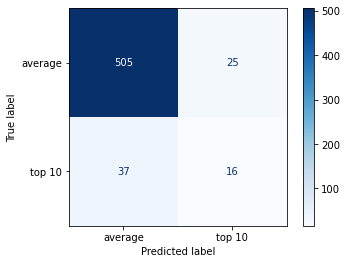

[(0.5316576689096302, 'song_popularity'),
 (0.08485260278692461, 'artist followers'),
 (0.06082843261461113, 'danceability'),
 (0.05453768805850356, 'liveness'),
 (0.04467099117787253, 'energy'),
 (0.03685991984902877, 'tempo'),
 (0.033479271491103385, 'duration_ms'),
 (0.030372837100890733, 'speechiness'),
 (0.026844801688536403, 'acousticness'),
 (0.02367119129116226, 'pop'),
 (0.018259152708327987, 'valence'),
 (0.015877575171279395, 'key'),
 (0.015844723085203, 'loudness'),
 (0.007370210402872564, 'mode'),
 (0.004541078216315399, 'instrumentalness'),
 (0.0042736633042193654, 'rock'),
 (0.0034981456733109368, 'time_signature'),
 (0.001415226779297712, 'artist popularity'),
 (0.0011448196908986376, 'rnb'),
 (1.130290305795199e-14, 'explicit'),
 (5.8980598183209144e-18, 'artist'),
 (0.0, 'rap'),
 (0.0, 'mellow'),
 (0.0, 'latin'),
 (0.0, 'hiphop'),
 (0.0, 'edm'),
 (0.0, 'country')]

In [12]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(class_weight = 'balanced')

#train model
clf = clf.fit(X_train, y_train)

#test model
print(f"Training Data Score: {clf.score(X_train, y_train)}")
print(f"Testing Data Score: {clf.score(X_test, y_test)}\n")

predictions = clf.predict(X_test)
print(classification_report(y_test, predictions,
                            target_names=target_names))

plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Blues, display_labels=["average","top 10"])
plt.show()

feature_names = X.columns
sorted(zip(clf.feature_importances_, feature_names), reverse=True)

### Random Forest

Training Data Score: 1.0
Testing Data Score: 0.9193825042881647

              precision    recall  f1-score   support

    negative       0.92      1.00      0.96       530
    positive       0.80      0.15      0.25        53

    accuracy                           0.92       583
   macro avg       0.86      0.57      0.61       583
weighted avg       0.91      0.92      0.89       583



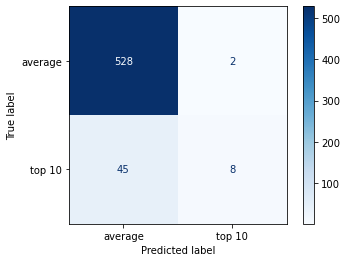

[(0.25873558689348775, 'song_popularity'),
 (0.06320835218723557, 'danceability'),
 (0.05535842366837345, 'liveness'),
 (0.05508626275840482, 'artist popularity'),
 (0.054031544147543666, 'speechiness'),
 (0.05305384771899743, 'artist followers'),
 (0.051858031689154635, 'valence'),
 (0.05083561875529956, 'duration_ms'),
 (0.047925830015447486, 'acousticness'),
 (0.04740041560153298, 'loudness'),
 (0.04714856207387043, 'energy'),
 (0.04676689866745599, 'tempo'),
 (0.04070704240871274, 'artist'),
 (0.03151029331349449, 'key'),
 (0.029856432633717365, 'instrumentalness'),
 (0.010585657720439014, 'pop'),
 (0.007640595074932863, 'rap'),
 (0.0074587839270797976, 'mode'),
 (0.006554687510391875, 'hiphop'),
 (0.0063951347432075365, 'mellow'),
 (0.006088272767382405, 'rnb'),
 (0.005853657609819516, 'explicit'),
 (0.004549071521340737, 'rock'),
 (0.0038328880240626733, 'time_signature'),
 (0.0032753780947817855, 'edm'),
 (0.0023026935921507947, 'country'),
 (0.0019800368816826792, 'latin')]

In [13]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=200)

#train model
rf = rf.fit(X_train, y_train)

#test model
print(f"Training Data Score: {rf.score(X_train, y_train)}")
print(f"Testing Data Score: {rf.score(X_test, y_test)}\n")

predictions = rf.predict(X_test)
print(classification_report(y_test, predictions,
                            target_names=target_names))

plot_confusion_matrix(rf, X_test, y_test, cmap=plt.cm.Blues, display_labels=["average","top 10"])
plt.show()

feature_names = X.columns
sorted(zip(rf.feature_importances_, feature_names), reverse=True)

### KNN

k: 1, Train/Test Score: 1.000/0.871
k: 3, Train/Test Score: 0.931/0.909
k: 5, Train/Test Score: 0.923/0.909
k: 7, Train/Test Score: 0.920/0.909
k: 9, Train/Test Score: 0.918/0.909
k: 11, Train/Test Score: 0.916/0.909
k: 13, Train/Test Score: 0.916/0.909
k: 15, Train/Test Score: 0.916/0.909
k: 17, Train/Test Score: 0.916/0.909
k: 19, Train/Test Score: 0.916/0.909


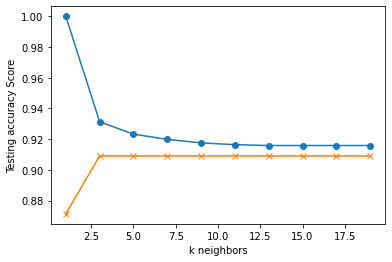

In [14]:
# PART 1

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

# Create a StandardScaler model and fit it to the training data
X_scaler = StandardScaler().fit(X_train)

# Transform the training and testing data using the X_scaler and y_scaler models
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Loop through different k values to see which has the highest accuracy
train_scores = []
test_scores = []
for k in range(1, 20, 2):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    train_score = knn.score(X_train_scaled, y_train)
    test_score = knn.score(X_test_scaled, y_test)
    train_scores.append(train_score)
    test_scores.append(test_score)
    print(f"k: {k}, Train/Test Score: {train_score:.3f}/{test_score:.3f}")
    
    
plt.plot(range(1, 20, 2), train_scores, marker='o')
plt.plot(range(1, 20, 2), test_scores, marker="x")
plt.xlabel("k neighbors")
plt.ylabel("Testing accuracy Score")
plt.show()

Training Data Score: 0.9232970807097882
Testing Data Score: 0.9090909090909091

              precision    recall  f1-score   support

    negative       0.91      1.00      0.95       530
    positive       0.00      0.00      0.00        53

    accuracy                           0.91       583
   macro avg       0.45      0.50      0.48       583
weighted avg       0.83      0.91      0.87       583



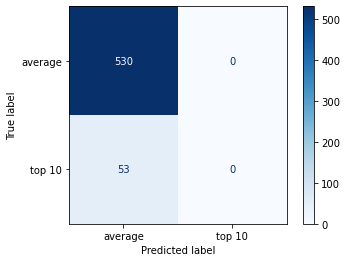

[(0.25873558689348775, 'song_popularity'),
 (0.06320835218723557, 'danceability'),
 (0.05535842366837345, 'liveness'),
 (0.05508626275840482, 'artist popularity'),
 (0.054031544147543666, 'speechiness'),
 (0.05305384771899743, 'artist followers'),
 (0.051858031689154635, 'valence'),
 (0.05083561875529956, 'duration_ms'),
 (0.047925830015447486, 'acousticness'),
 (0.04740041560153298, 'loudness'),
 (0.04714856207387043, 'energy'),
 (0.04676689866745599, 'tempo'),
 (0.04070704240871274, 'artist'),
 (0.03151029331349449, 'key'),
 (0.029856432633717365, 'instrumentalness'),
 (0.010585657720439014, 'pop'),
 (0.007640595074932863, 'rap'),
 (0.0074587839270797976, 'mode'),
 (0.006554687510391875, 'hiphop'),
 (0.0063951347432075365, 'mellow'),
 (0.006088272767382405, 'rnb'),
 (0.005853657609819516, 'explicit'),
 (0.004549071521340737, 'rock'),
 (0.0038328880240626733, 'time_signature'),
 (0.0032753780947817855, 'edm'),
 (0.0023026935921507947, 'country'),
 (0.0019800368816826792, 'latin')]

In [15]:
# PART 2

# Note that k: 5 seems to be the best choice for this dataset
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

#test model
print(f"Training Data Score: {knn.score(X_train_scaled, y_train)}")
print(f"Testing Data Score: {knn.score(X_test_scaled, y_test)}\n")

predictions = knn.predict(X_test)
print(classification_report(y_test, predictions,
                            target_names=target_names))

plot_confusion_matrix(knn, X_test, y_test, cmap=plt.cm.Blues, display_labels=["average","top 10"])
plt.show()

feature_names = X.columns
sorted(zip(rf.feature_importances_, feature_names), reverse=True)